In [29]:
import kagglehub
import os
import warnings

warnings.filterwarnings("ignore")
dataset_path = kagglehub.dataset_download("imsparsh/flowers-dataset")
print("Path to dataset files:", dataset_path)

print("\nDataset contents:")
print(os.listdir(dataset_path))

Path to dataset files: /home/almirante_ming/.cache/kagglehub/datasets/imsparsh/flowers-dataset/versions/2

Dataset contents:
['LICENSE.txt', 'Testing_set_flower.csv', 'sample_submission.csv', 'test', 'train']


In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras import layers, models
from sklearn.metrics import classification_report, confusion_matrix

In [31]:
submission_path = os.path.join(dataset_path, 'sample_submission.csv')
if os.path.exists(submission_path):
    df = pd.read_csv(submission_path)
    df.head()
else:
    print(f"Note: sample_submission.csv not found in {dataset_path}")
    print("Available files:", os.listdir(dataset_path))
    
df.columns

Index(['prediction'], dtype='object')

In [32]:
train_path = os.path.join(dataset_path, 'train')
class_names = sorted(os.listdir(train_path))
print("Classes:", class_names)

Classes: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


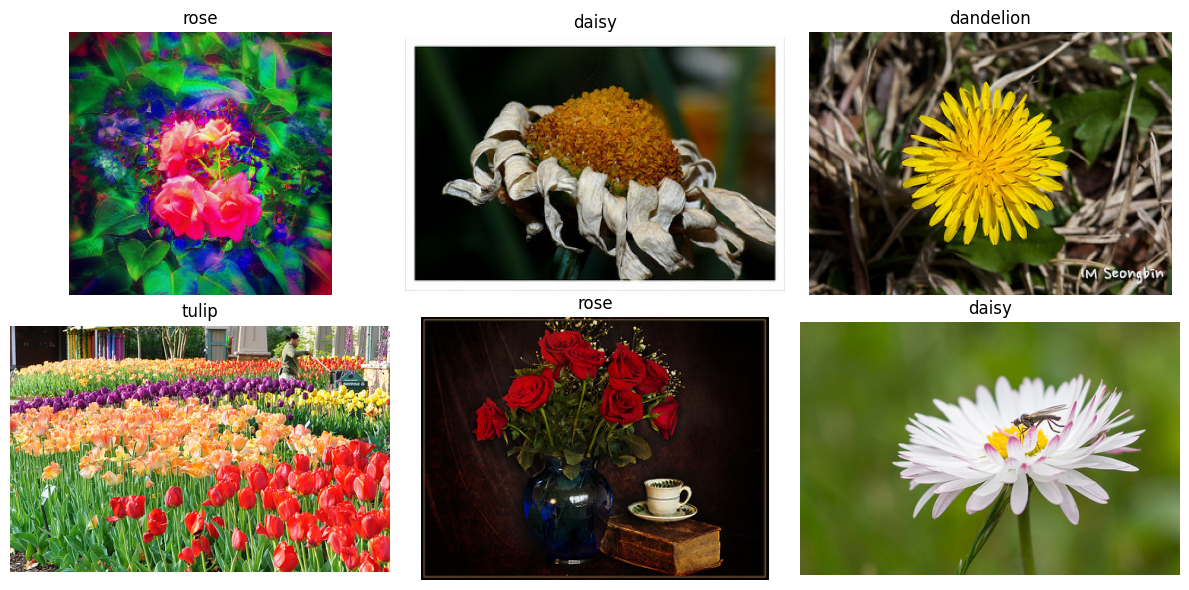

In [33]:
import matplotlib.image as mpimg
import random

plt.figure(figsize=(12, 6))
for i in range(6):
    class_name = random.choice(class_names)
    img_name = random.choice(os.listdir(os.path.join(train_path, class_name)))
    img_path = os.path.join(train_path, class_name, img_name)
    img = mpimg.imread(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

In [34]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)

datagen = ImageDataGenerator(
    validation_split=0.2,
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2
)

train_gen = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

val_gen = datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


In [35]:
base_model = EfficientNetB0(include_top=False, input_shape=(224, 224, 3), weights='imagenet')
base_model.trainable = False  # Freeze weights

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(len(class_names), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,378,792 (16.70 MB)

 Trainable params: 329,221 (1.26 MB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [36]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5
)

Epoch 1/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.2197 - loss: 1.6438 - val_accuracy: 0.2208 - val_loss: 1.6131
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.2197 - loss: 1.6438 - val_accuracy: 0.2208 - val_loss: 1.6131
Epoch 2/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.2234 - loss: 1.6106 - val_accuracy: 0.2354 - val_loss: 1.6039
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 74s 1s/step - accuracy: 0.2234 - loss: 1.6106 - val_accuracy: 0.2354 - val_loss: 1.6039
Epoch 3/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2243 - loss: 1.6071 - val_accuracy: 0.2354 - val_loss: 1.6065
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.2243 - loss: 1.6071 - val_accuracy: 0.2354 - val_loss: 1.6065
Epoch 4/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.2325 - loss: 1.6098 - val_accuracy: 0.2354 - val_loss: 1.6049
Epoch 5/5
69/69 ━━━━━━━━━━━━━━━━━━━━ 188s 3s/step - accuracy: 0.2325 - loss: 1.6098 - val_accuracy: 0.2354 - val_loss: 1.604

18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 34s 2s/step
              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00       100
   dandelion       0.24      1.00      0.38       129
        rose       0.00      0.00      0.00        99
   sunflower       0.00      0.00      0.00        99
       tulip       0.00      0.00      0.00       121

    accuracy                           0.24       548
   macro avg       0.05      0.20      0.08       548
weighted avg       0.06      0.24      0.09       548

              precision    recall  f1-score   support

       daisy       0.00      0.00      0.00       100
   dandelion       0.24      1.00      0.38       129
        rose       0.00      0.00      0.00        99
   sunflower       0.00      0.00      0.00        99
       tulip       0.00      0.00      0.00       121

    accuracy                           0.24       548
   macro avg       0.05      0.20      0.08       548

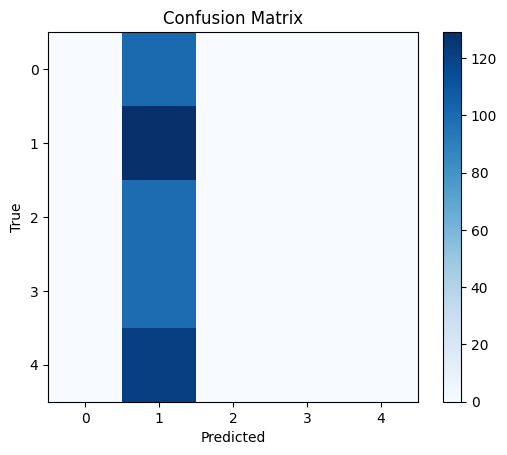

In [39]:
val_gen.reset()
preds = model.predict(val_gen, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = val_gen.classes

print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.imshow(cm, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.colorbar()
plt.show()

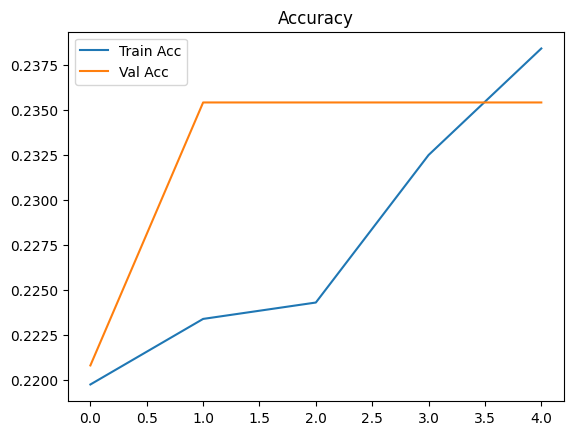

In [38]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title("Accuracy")
plt.show()